# Project Final Report

Group Member: Mia , Selima, Daniel 

## (1) Introduction

The project that we are working on surrounds the prediction of the usage of a video game research server. We are provided two datasets as a supplement to answer any predictive questions we came up with. This dataset is provided by the Pacific Laboratory for Artificial Intelligence, and they aim to understand in more detail the actions of players in the video game, Minecraft.


>**Question:** How does the amount of hours a player spend on the server, and the number of sessions can accurately predict gender?

- The number of sessions and the amount of hours are the predictor variables
- The gender of players is the response variable of interest


## (2) Methods & Results

We first load the data using HTML form, which allows us to see the dataset in the CSV format. Then, we select the variables in question: hashedEmail, played_hours, and gender from the players.csv dataset, and hashedEmail, sessioncount from the second dataset. We join the two datasets together. 


In [12]:
library(tidyverse)
library(repr)
library(tidymodels)
library(dplyr)
options(repr.matrix.max.rows = 6)

### (1) Data Description:
The players.csv dataset contains observations of players of a Minecraft server:
- 196 observations (players)
- each player is described by 9 variables

|Column Name      |Data Type |Description                                                                 | 
|-----------------|:---------|:---------------------------------------------------------------------------|
|experience       |character |level of experience of the player (Pro, Veteran, Amateur, Regular, Beginner)|
|subscribe        |logical   |indicates if the player has subscribed                                      |
|hashedEmail      |character |anonymous player emails                                                     |
|played_hours     |double    |number of hours the player has spent on the server                          |
|name             |character |name of the player                                                          |
|gender           |character |gender of the player                                                        |
|age              |double    |age of the player                                                           |
|individualId     |logical   |possibly an identifier for specific groups                                  |
|organizationName |logical   |possibly intended for organizations linked to players                       |

The sessions.csv dataset contains observations of each player's playing session:
- 1535 observations (sessions)
- 5 variables
 
|Column Name         |Data Type |Description                                              | 
|--------------------|:---------|:--------------------------------------------------------|
|hashedEmail         |character |anonymous player emails                                  |
|start_time          |character |start date and time of a session                         |
|end_time            |character |end date and time of a session                           |
|original_start_time |double    |scheduled start time in UNIX timestamp format            |
|original_end_time   |double    |scheduled end time in UNIX timestamp format              |


### (2) Question: 

My analysis aims to determine if the number of hours a player spends on the server and their session count can accurately predict gender. This question addresses the broader objective of understanding which player types contribute the most data (question 1). Predicting gender based on playtime and session frequency allows segmentation, helping identify player behaviours correlated with data contribution. By grouping players by gender (e.g., male, female, non-binary, etc.), targeted recruitment can focus on those more likely to engage extensively with the game. For instance, if males generally play the longest, targeting them might yield higher-quality data.

### (3) Exploratory Data Analysis and Visualization

In [49]:

#loading libarary to read the google drive link
library(httr)
library(readr)

# Loading player dataset
url_player <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"

# Download the file
temp_file <- tempfile(fileext = ".csv")
GET(url_player, write_disk(temp_file))

players <- read_csv(temp_file)|>
  select(hashedEmail, played_hours, gender)

# Loading session dataset
url_sessions <- "https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB"

temp_file <- tempfile(fileext = ".csv") # Adjust extension if not a CSV
GET(url_sessions, write_disk(temp_file))

sessions <- read_csv(temp_file)|> 
    select(hashedEmail) |>
    group_by(hashedEmail) |>
    summarize(session_count = n())

data <- left_join(sessions, players, by = "hashedEmail")|>
    mutate(gender = as_factor(gender))

data

Response [https://drive.usercontent.google.com/download?id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz&export=download]
  Date: 2024-11-28 00:27
  Status: 200
  Content-Type: application/octet-stream
  Size: 19.6 kB
<ON DISK>  /tmp/RtmpwYEgmS/filec9a62d3424b.csvNULL

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Response [https://drive.usercontent.google.com/download?id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB&export=download]
  Date: 2024-11-28 00:27
  Status: 200
  Content-Type: application/octet-stream
  Size: 189 kB
<ON DISK>  /tmp/RtmpwYEgmS/filec9a4980ff7b.csvNULL

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,session_count,played_hours,gender
<chr>,<int>,<dbl>,<fct>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,2,1.5,Male
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,1,0.4,Male
0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,1,0.1,Male
⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,310,56.1,Male
fe218a05c6c3fc6326f4f151e8cb75a2a9fa29e22b110d4c311fb58fb211f471,1,0.1,Male
fef4e1bed8c3f6dcd7bcd39ab21bd402386155b2ff8c8e53683e1d2793bf1ed1,1,1.1,Male


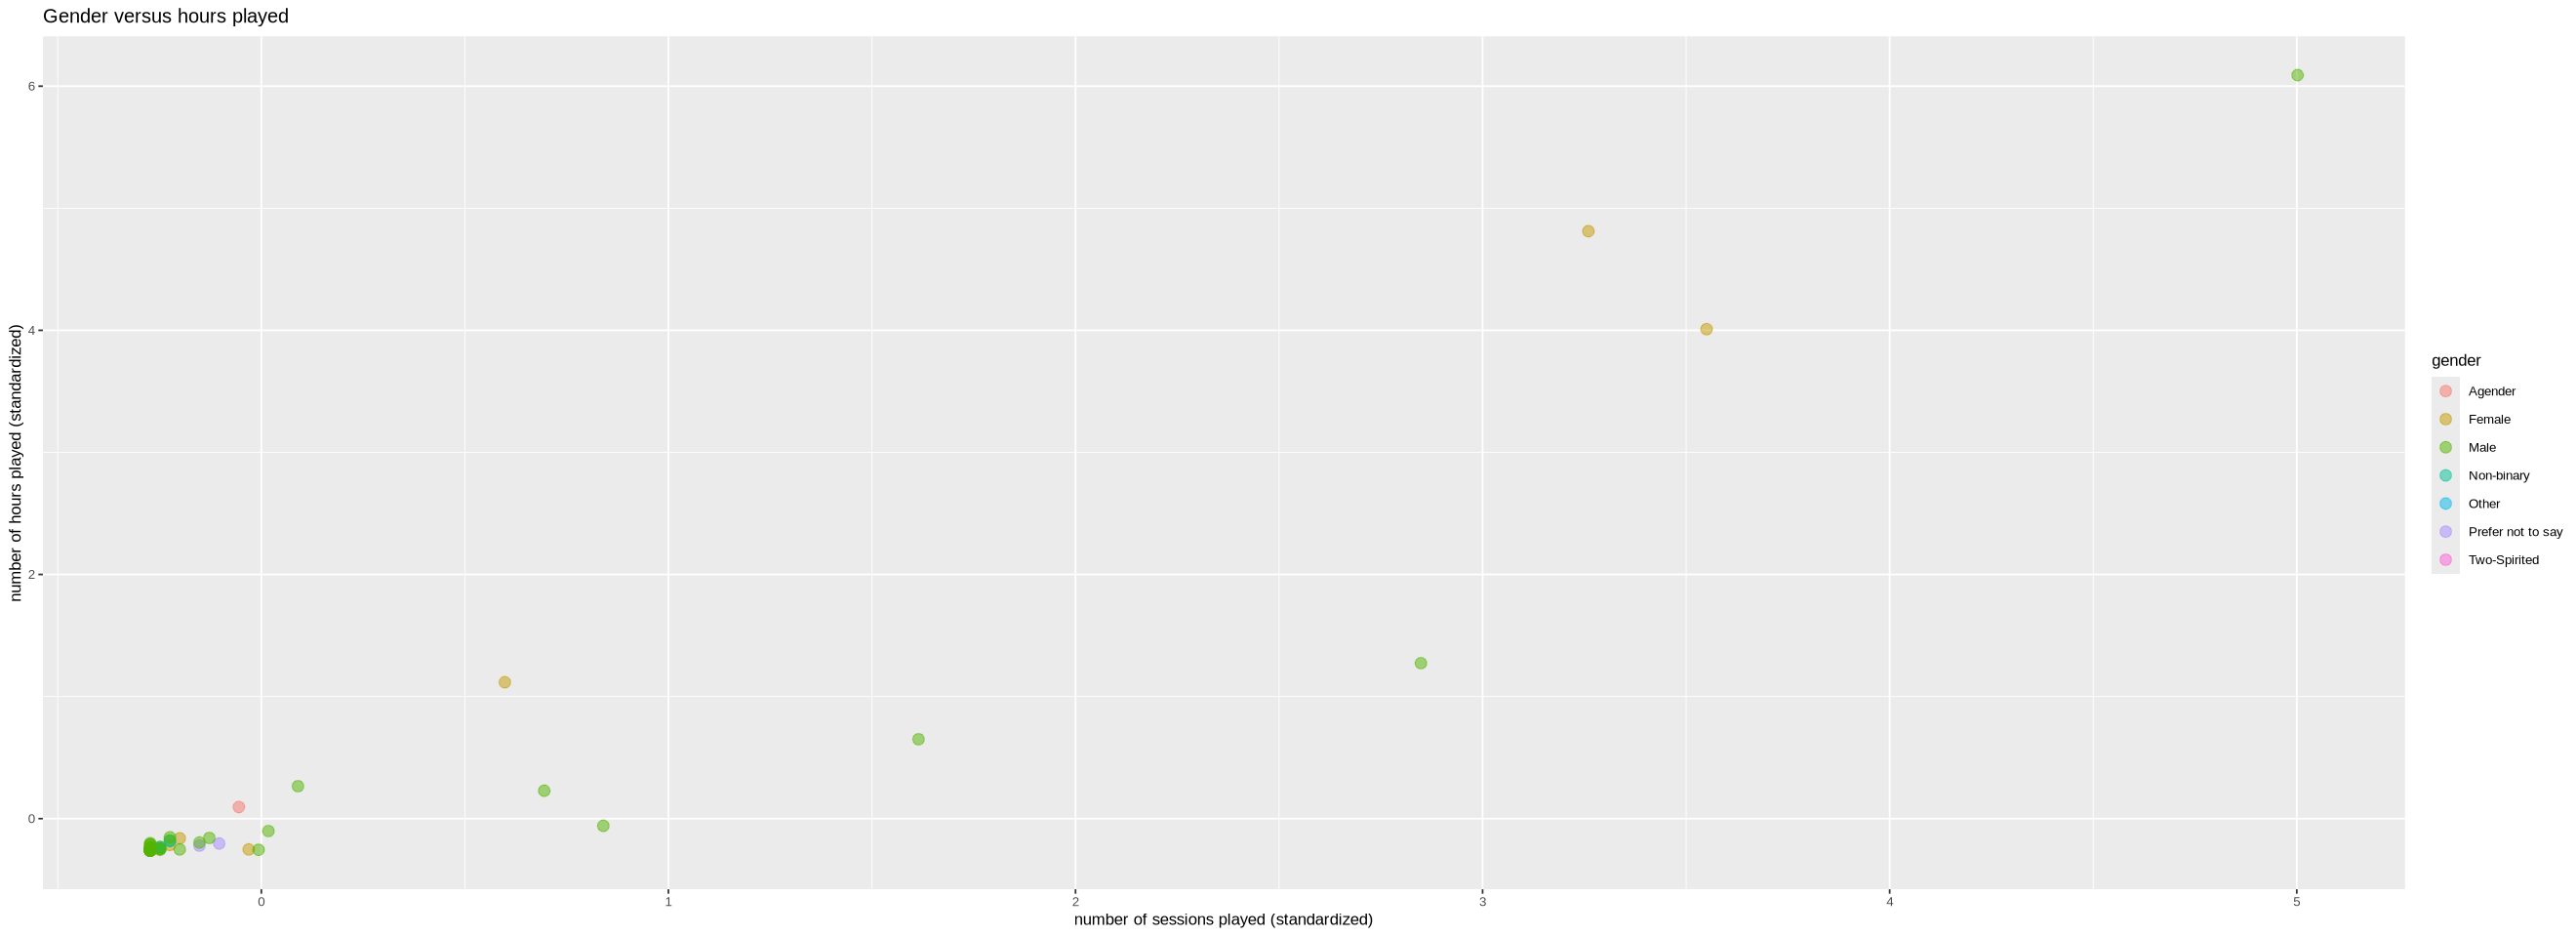

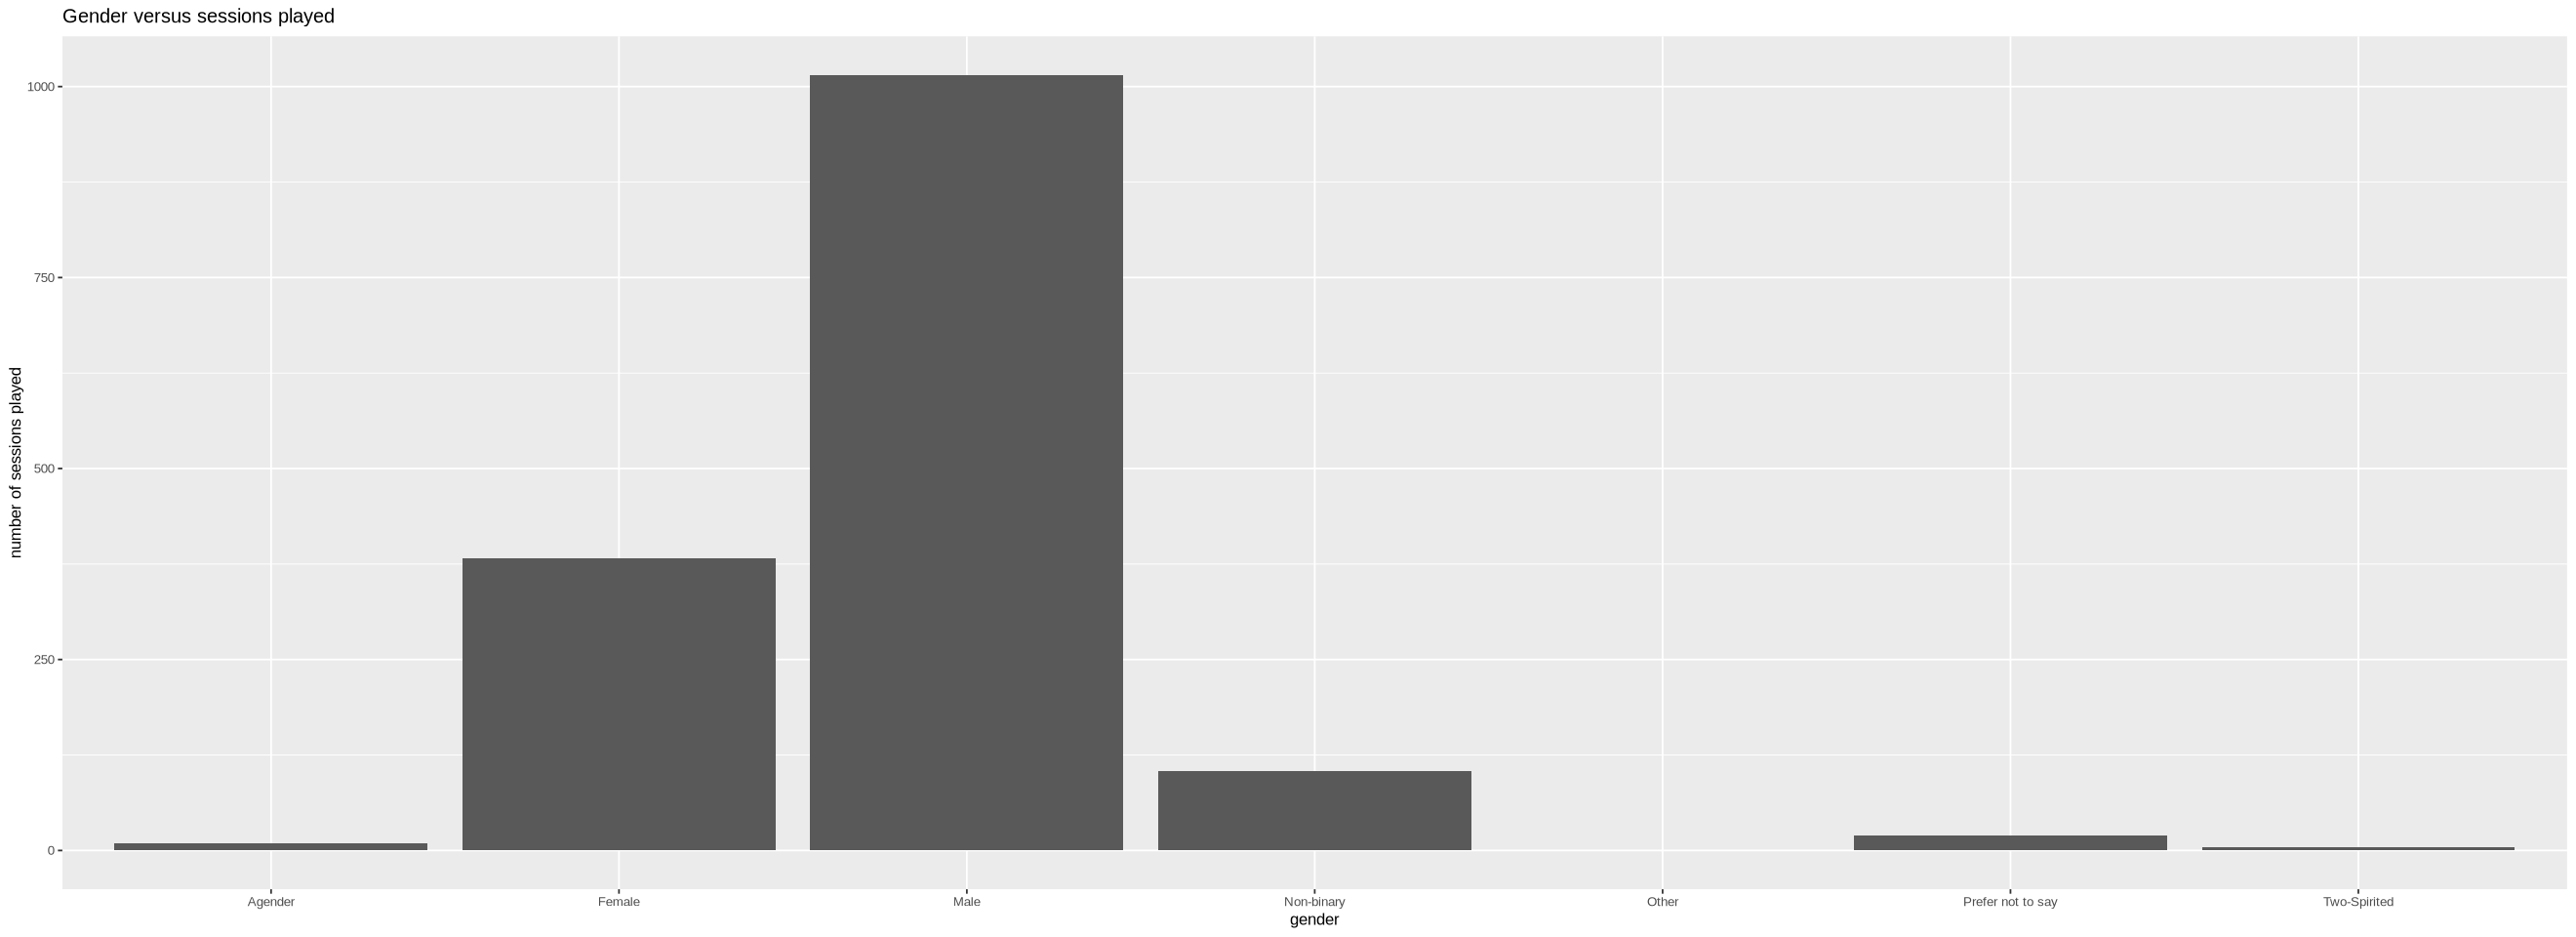

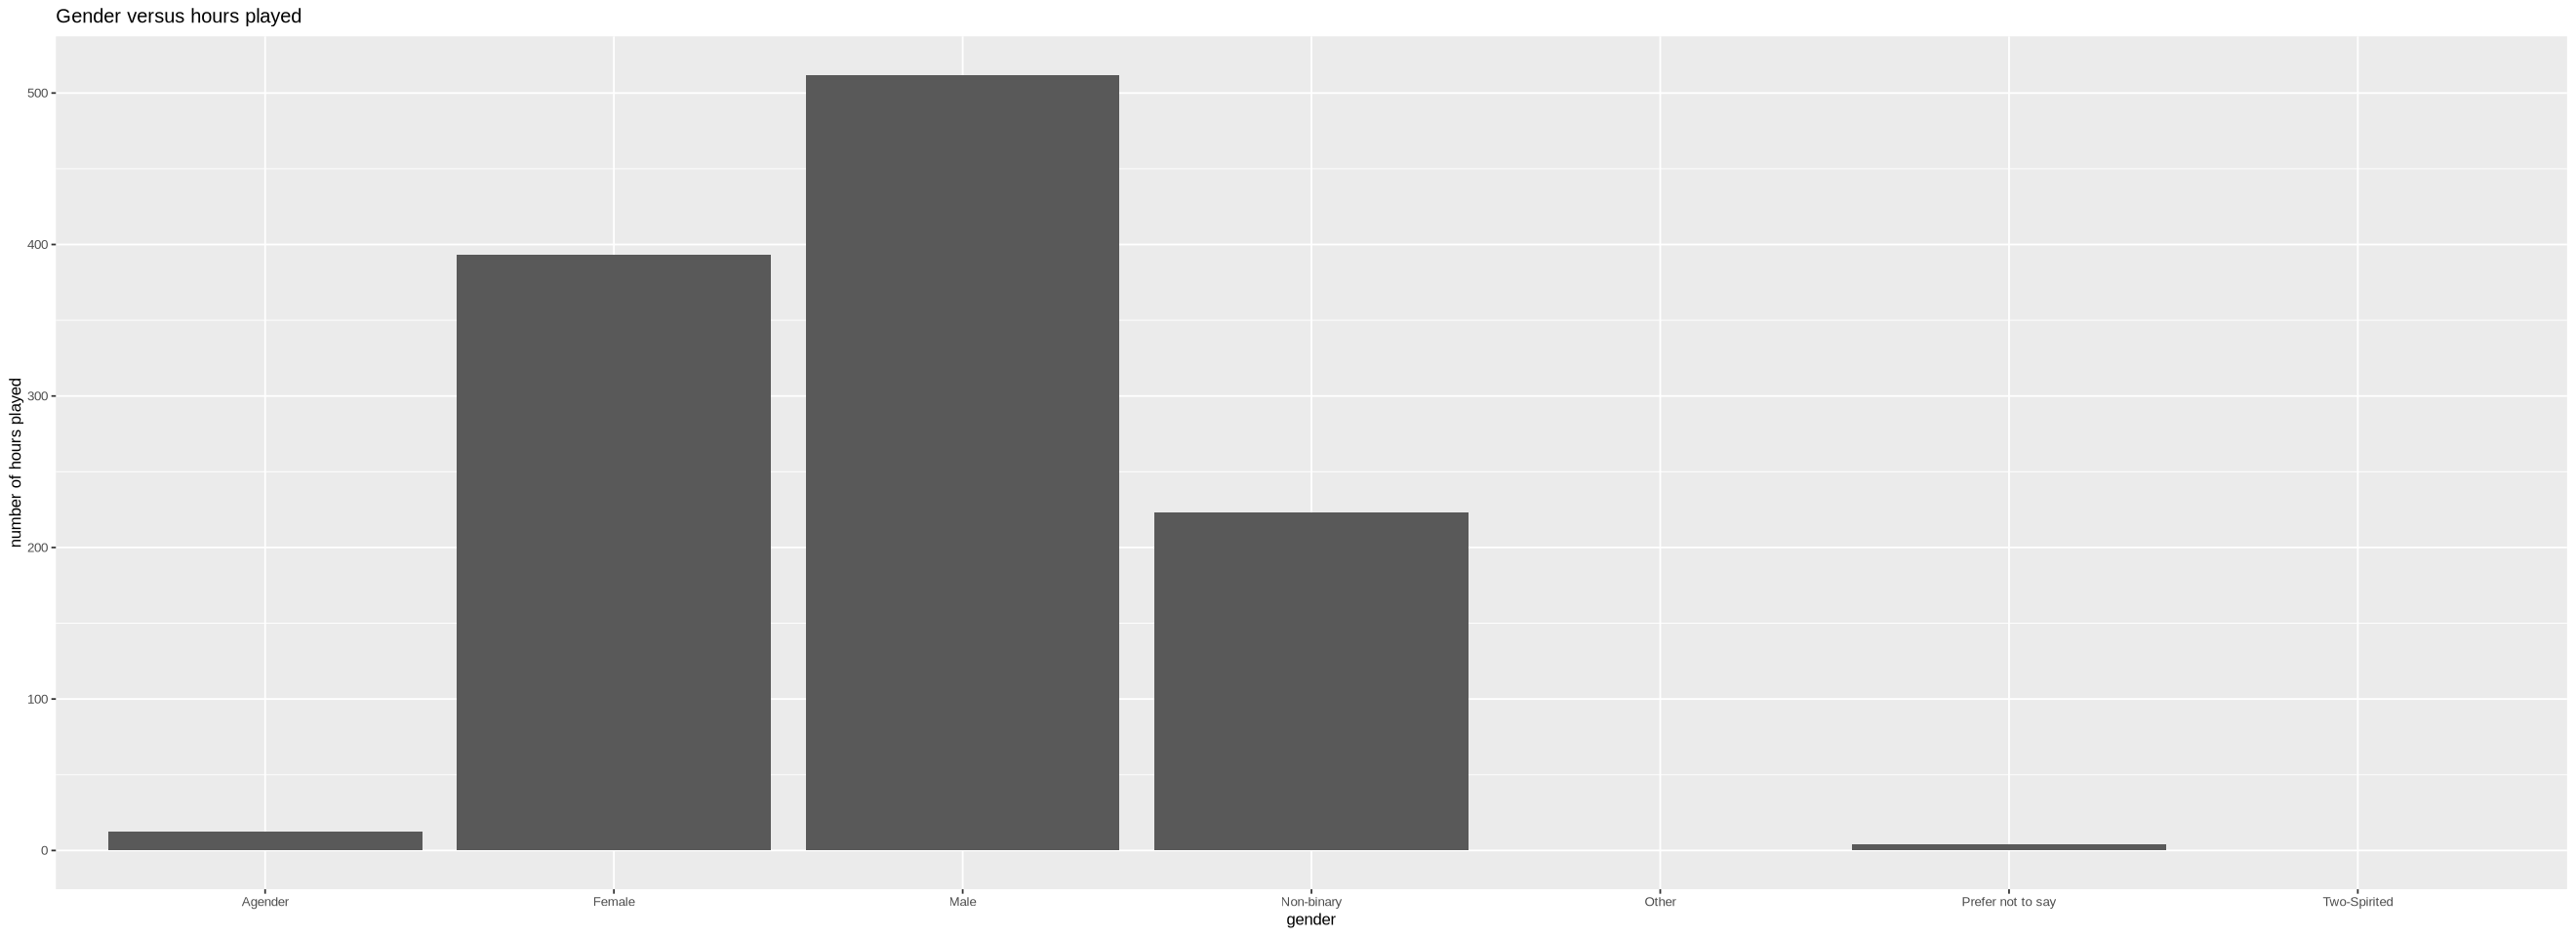

In [43]:
set.seed(9999) 

#scale and center the data
data_recipe <- recipe(gender ~ session_count + played_hours, data = data) |>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())

data_scaled <- data_recipe |>  
                            prep() |> 
                           bake(data)

#split 70% of the data into the training set and the rest into testing
data_split <- initial_split(data_scaled, prop = 0.70, strata = gender)
data_train <- training(data_split)
data_test <- testing(data_split)

#create a scatterplot of the number of sessions played (standardized) and the number of hours played (standardized) and see the distribution of genders
options(repr.plot.width = 22, repr.plot.height = 8) 
data_scatterplot <- data_train|>
    ggplot(aes(x = session_count, y = played_hours, colour = gender)) +
        geom_point(alpha = 0.5, cex = 3) +
        labs(x = "number of sessions played (standardized)", y = "number of hours played (standardized)", colour = "gender") +
        theme(text = element_text(size = 10)) +
        ggtitle("Gender versus hours played")


#create a bar plot comparing gender and session count
data_bar1 <- ggplot(data, aes(x = gender, y = session_count)) +
  geom_bar(stat = "identity") +
  xlab("gender") +
  ylab("number of sessions played") +
  theme(text = element_text(size = 10)) +
  ggtitle("Gender versus sessions played")

#create a bar plot comparing gender and hours played
data_bar2 <- ggplot(data, aes(x = gender, y = played_hours)) +
  geom_bar(stat = "identity") +
  xlab("gender") +
  ylab("number of hours played") +
  theme(text = element_text(size = 10)) +
  ggtitle("Gender versus hours played")



data_scatterplot
data_bar1
data_bar2

In [51]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

cv_folds <- vfold_cv(data_train, v = 5, strata = gender)

workflow_knn <- workflow() |>
    add_recipe(data_recipe) |>
    add_model(knn_spec)

k_vals <- tibble(neighbors = c(2, 3, 4, 5, 6))

knn_results <- workflow_knn |>
    tune_grid(
        resamples = cv_folds,
        grid = k_vals
    ) |>
    collect_metrics()

accuracies <- knn_results |>
    filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    scale_x_continuous(breaks = seq(0, 14, by = 1)) +
    scale_y_continuous(limits = c(0.4, 1.0))

cross_val_plot


→ A | error:   ✖ The following variables have the wrong class:
               • `session_count` must have class <numeric>, not <integer>.
               • `gender` must have class <factor>, not <character>.

There were issues with some computations   A: x1

There were issues with some computations   A: x5



Warning message:
“All models failed. Run `show_notes(.Last.tune.result)` for more information.”


ERROR: [1m[33mError[39m in `estimate_tune_results()`:[22m
[33m![39m All models failed. Run `show_notes(.Last.tune.result)` for more information.
